## Timeseries forecasting - WiDS 2023 Challenge

Goal is to predict the mean of the max and min observed temperature over a two-week period for each location and start date.

In [1]:
# Base libraries
import numpy as np
import pandas as pd
import itertools

In [14]:
# Stats and ML libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
from prophet import Prophet

In [3]:
# Plotting libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(rc={"figure.figsize":(8, 4), "figure.dpi":300}) # width=8, height=4

In [4]:
import warnings
warnings.filterwarnings("ignore") 

In [5]:
# Read in the datasets
df = pd.read_csv("train_data.csv")
df = df.set_index('index') # Set column 'index' as the index of rows

test_df = pd.read_csv("test_data.csv")
test_df = test_df.set_index('index')

In [6]:
def process_date(df):
    # Convert datetime into pandas parsable format
    df["startdate"] = pd.to_datetime(df["startdate"])

    # Extract day, month and year from startdate column
    df['day'] = df['startdate'].dt.day
    df['month'] = df['startdate'].dt.month
    df['year'] = df['startdate'].dt.year
    # df = df.drop(columns=['startdate'])
    
    return df

In [7]:
df = process_date(df)
test_df = process_date(test_df)

In [8]:
def add_season(dataframe):
    month_to_season = {12: 0, 1: 0, 2: 0,
                       3: 1, 4: 1, 5: 1,
                       6: 2, 7: 2, 8: 2,
                       9: 3, 10: 3, 11: 3}
    dataframe['season'] = dataframe['month'].apply(lambda x: month_to_season[x])
    return dataframe

In [9]:
df = add_season(df)
test_df = add_season(test_df)

## Visualize data to start

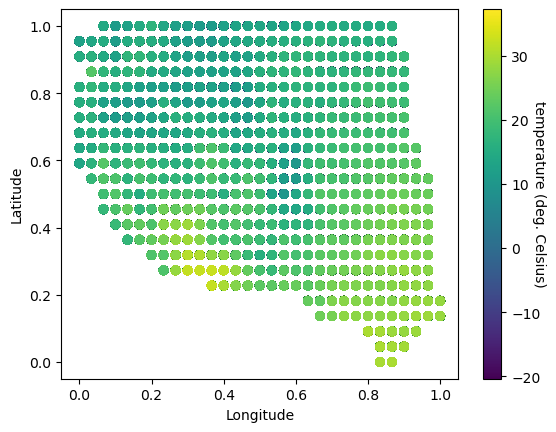

In [10]:
#  Plot temperature by location 
fig = plt.scatter(x=df['lon'], y=df['lat'], c=df['contest-tmp2m-14d__tmp2m'])  # can also shade as climatic regions
cbar = plt.colorbar(fig)
cbar.set_label('temperature (deg. Celsius)', rotation=270)
plt.xlabel('Longitude'); plt.ylabel('Latitude')
# plt.savefig("temp_distribution.png", format="png")
plt.show()

Lower latitudes and higher longitudes have warmer temperatures.

<Axes: xlabel='contest-tmp2m-14d__tmp2m', ylabel='Density'>

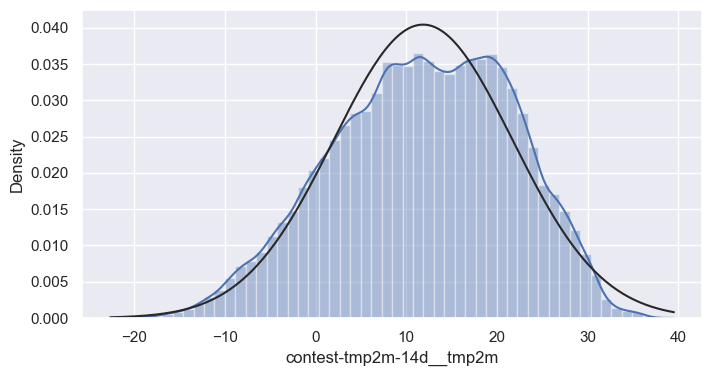

In [11]:
# Plot the distribution of the target variable along with the standard gaussian curve
sns.set(rc={"figure.figsize": (8, 4)}); np.random.seed(0)
sns.distplot(df['contest-tmp2m-14d__tmp2m'], fit=norm)

The distribution of the target variable is close to gaussian.

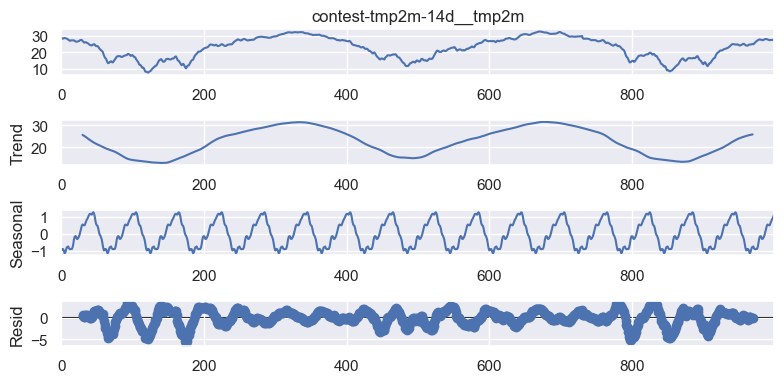

In [17]:
# Perform a time series decomposition of the target variable
def decomposition(input_df: pd.DataFrame,
                  decomposition_type: str = 'multiplicative',
                  period: int = 60):

    decomposed = seasonal_decompose(input_df, model=decomposition_type, period=period)
    decomposed.plot()
    return

# Plot the time series decomposition of the training dataset
# Only the first 10,000 samples are plotted for better visualization
decomposition(df['contest-tmp2m-14d__tmp2m'][:1000], decomposition_type = 'additive')

The time series is highly seasonal and has no rising or falling trend. Same results whether using an additive or multtiplicative decomposition type.

In [18]:
# The Augmented Dickey-Fuller test is used to determine how strongly a time series is 
# defined by a trend. The null hypothesis is that time series is not stationary.

def adfuller_test(input_df: pd.Series, signif: float = 0.05) -> None:

  r = adfuller(input_df)
  return r

adfuller_test(df['contest-tmp2m-14d__tmp2m'][:100000])

(-37.95876572481009,
 0.0,
 68,
 99931,
 {'1%': -3.4304154398333235,
  '5%': -2.861568923380865,
  '10%': -2.5667853949035773},
 -10110.918171636382)

The test statistic is lower than 1%, 5% and 10%  critical values. p-value is also much less than the significant value 0.05. So, the null hypothesis is rejected and the data is considered to be stationary.

## Examine correlations

In [21]:
# Explore correlations between numerical features and the target variable for numerical features
numeric_features = df.select_dtypes(include=['float64']).columns.values

# Removing physics-based models as predictors, and wind / ice
ind = -1
ind_to_remove = []
feat_to_remove = []
for feat in numeric_features:
    ind += 1
    if 'nmme' in feat or 'wind' in feat or 'ice' in feat or 'sst' in feat: 
        ind_to_remove.append(ind)
        feat_to_remove.append(feat)

phys_models = ['cancm30', 'cancm40', 'ccsm30', 'ccsm40', 'cfsv20', 'gfdlflora0', 'gfdlflorb0', 'gfdl0', 'nasa0']
for model in phys_models:
        ind_match = int(np.where(numeric_features == model)[0])         
        ind_to_remove.append(ind_match)
        feat_to_remove.append(numeric_features[ind_match])
    
numeric_feat_trim = np.delete(numeric_features, ind_to_remove)

<Axes: >

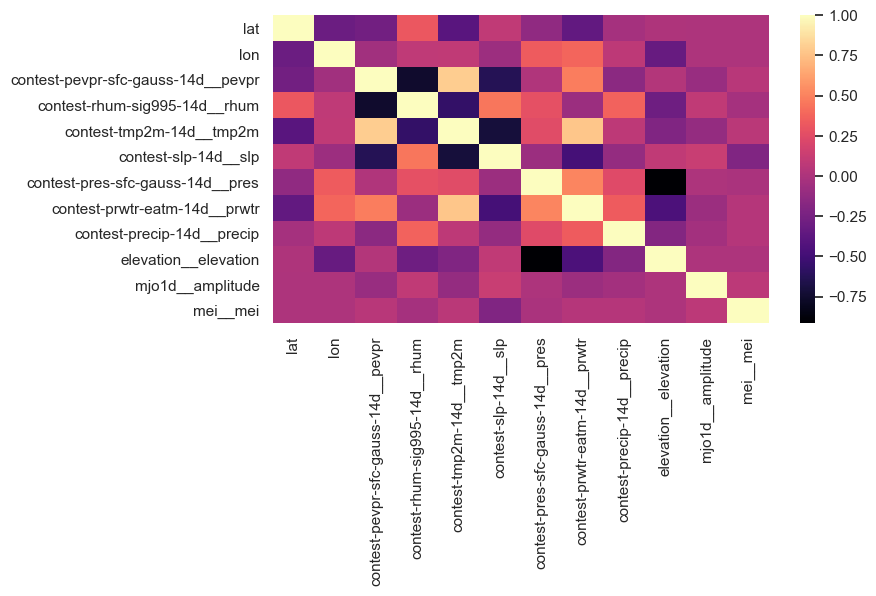

In [20]:
# Compute correlations between all numerical features and plot the heatmap
df_corr = df[numeric_feat_trim].corr()
sns.heatmap(df_corr,cmap='magma')

In [22]:
# Sort features by their (absolute) correlation with the target variable
df_corr.sort_values(by='contest-tmp2m-14d__tmp2m', key=abs, ascending=False)['contest-tmp2m-14d__tmp2m']

contest-tmp2m-14d__tmp2m              1.000000
contest-pevpr-sfc-gauss-14d__pevpr    0.805301
contest-prwtr-eatm-14d__prwtr         0.772465
contest-slp-14d__slp                 -0.707640
contest-rhum-sig995-14d__rhum        -0.565127
lat                                  -0.398388
contest-pres-sfc-gauss-14d__pres      0.244318
elevation__elevation                 -0.207810
mjo1d__amplitude                     -0.115210
lon                                   0.092923
contest-precip-14d__precip            0.079041
mei__mei                              0.061639
Name: contest-tmp2m-14d__tmp2m, dtype: float64

In [24]:
# Based on above, start with these predictors
predictors = ['contest-prwtr-eatm-14d__prwtr', 'contest-rhum-sig995-14d__rhum', 'contest-slp-14d__slp', 'contest-pevpr-sfc-gauss-14d__pevpr']

X = df[predictors]
y = df['contest-tmp2m-14d__tmp2m']

# print(X.head())

In [34]:
# Scale values
scalar = MinMaxScaler()

values = X.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).values
test_values = test_df[predictors].select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).values

scalar.fit(values) # fit only on the train dataset

values_scaled = scalar.transform(values)
test_values_scaled = scalar.transform(test_values)

In [35]:
# Create dataframe on scaled values
X = pd.DataFrame(values_scaled, columns=X.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns, index=df.index)
test_X = pd.DataFrame(test_values_scaled, columns=test_df[predictors].select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns, index=test_df[predictors].index)

In [36]:
X.columns

Index(['contest-prwtr-eatm-14d__prwtr', 'contest-rhum-sig995-14d__rhum',
       'contest-slp-14d__slp', 'contest-pevpr-sfc-gauss-14d__pevpr'],
      dtype='object')

## Consider the location of temperature data points, specifically:
- Which lat/long pairings (referred to here forward as locations) are in which climate region?
- Is the temperature data (and other data) for each location aligned in time?

In [37]:
# Find number of unique lat/longs and lat/long pairings
print("unique lats:", len(df['lat'].unique()))
print("unique longs:", len(df['lon'].unique()))

df['lat_lon'] = df['lat'].astype(str) + '_' + df['lon'].astype(str)
test_df['lat_lon'] = test_df['lat'].astype(str) + '_' + test_df['lon'].astype(str)
print("unique lat/long combos (locations):", len(df['lat_lon'].unique()))

unique lats: 23
unique longs: 31
unique lat/long combos (locations): 514


In [38]:
dict_regions = {}

def climate_regions(dataframe):
    for region in dataframe['climateregions__climateregion'].unique():
        df_cr = dataframe[dataframe['climateregions__climateregion'] == region]
        dict_regions[region] = [len(df_cr['lat_lon'].unique()), df_cr['startdate'].min()]
        
    return dict_regions

In [39]:
dict_cr = climate_regions(df)
print("climate region: # of locs within region, data start date")
dict_cr

climate region: # of locs within region, data start date


{'BSh': [7, Timestamp('2014-09-01 00:00:00')],
 'Cfa': [71, Timestamp('2014-09-01 00:00:00')],
 'BSk': [191, Timestamp('2014-09-01 00:00:00')],
 'BWk': [19, Timestamp('2014-09-01 00:00:00')],
 'BWh': [13, Timestamp('2014-09-01 00:00:00')],
 'Csa': [13, Timestamp('2014-09-01 00:00:00')],
 'Csb': [56, Timestamp('2014-09-01 00:00:00')],
 'Cfb': [6, Timestamp('2014-09-01 00:00:00')],
 'Dfb': [72, Timestamp('2014-09-01 00:00:00')],
 'Dsc': [4, Timestamp('2014-09-01 00:00:00')],
 'Dfc': [17, Timestamp('2014-09-01 00:00:00')],
 'Dfa': [31, Timestamp('2014-09-01 00:00:00')],
 'Dsb': [11, Timestamp('2014-09-01 00:00:00')],
 'Dwa': [2, Timestamp('2014-09-01 00:00:00')],
 'Dwb': [1, Timestamp('2014-09-01 00:00:00')]}


Let's look at temperature timeseries for locations in four of the climate regions:

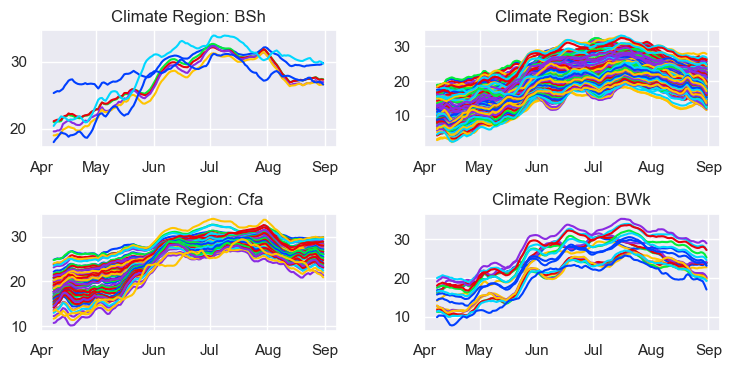

In [40]:
fig, axs = plt.subplots(2,2)
fig.tight_layout(pad=2)
plt.style.use('seaborn-v0_8-bright')
clear_labels = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
nrow = [0, 1, 0, 1]
ncol = [0, 0, 1, 1]
counter = 0

for region in df['climateregions__climateregion'].unique()[0:4]:
    
    # Get climate region
    df_cr = df[df['climateregions__climateregion'] == region]
    for ll_combo in df_cr['lat_lon'].unique():
        
        # Extract just one location
        df_ll = df_cr[df_cr['lat_lon'] == ll_combo]

        # Need the scaled dataset X for that location
        X_ll = X.loc[df_ll.index]
        y_ll = y.loc[df_ll.index]
        date_ll = df.loc[df_ll.index, ['startdate', 'month']]

        # Create train & test dataset for that location
        four_fifths = round(len(X_ll) * 0.8)
        
        X_ll_train = X_ll[0:four_fifths]
        y_ll_train = y_ll[0:four_fifths]
        
        X_ll_test = X_ll[four_fifths:]
        y_ll_test = y_ll[four_fifths:]
        
        axs[nrow[counter], ncol[counter]].plot(date_ll[four_fifths:]['startdate'], y_ll_test)
        ticks = axs[nrow[counter], ncol[counter]].get_xticks()
        axs[nrow[counter], ncol[counter]].set_xticks(ticks=ticks, labels=clear_labels)
        axs[nrow[counter], ncol[counter]].set_title("Climate Region: " + region)

    counter += 1

In [44]:
date_ll

,startdate,month
index,,
268277,2014-09-01,9
268278,2014-09-02,9
268279,2014-09-03,9
268280,2014-09-04,9
268281,2014-09-05,9
...,...,...
269003,2016-08-27,8
269004,2016-08-28,8
269005,2016-08-29,8


Model fitting
- Start by working with 1 location in 1 climate region - the last location in the BWh region

In [47]:
df_prophet_train = pd.concat([date_ll['startdate'][0:four_fifths], y_ll_train, X_ll_train], axis=1)
df_prophet_train = df_prophet_train.rename(columns={'startdate': 'ds', 'contest-tmp2m-14d__tmp2m': 'y'})
df_prophet_test = pd.concat([date_ll['startdate'][four_fifths:], y_ll_test, X_ll_test], axis=1)
df_prophet_test = df_prophet_test.rename(columns={'startdate': 'ds', 'contest-tmp2m-14d__tmp2m': 'y'})

In [48]:
df_prophet_train.columns

Index(['ds', 'y', 'contest-prwtr-eatm-14d__prwtr',
       'contest-rhum-sig995-14d__rhum', 'contest-slp-14d__slp',
       'contest-pevpr-sfc-gauss-14d__pevpr'],
      dtype='object')

In [49]:
# run algorithm
m = Prophet(growth='linear', daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)
for col in df_prophet_train.columns[2:]:
    m.add_regressor(col)
m.fit(df_prophet_train)
results = m.predict(df_prophet_test)

16:46:46 - cmdstanpy - INFO - Chain [1] start processing
16:46:47 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
plt.style.use('fivethirtyeight')
plt.plot(results['ds'], results['yhat'], label='predicted')
plt.plot(df_prophet_test['ds'], df_prophet_test['y'], label='actual')
plt.ylabel('mean temp, 14-day avg.', fontsize=16)
plt.legend()
plt.show()

In [9]:
# Adding cyclical feature engineering
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


def encode_cyclical(dataframe):
    # Encode the day with a period of 365
    dataframe['day_of_year_sin'] = sin_transformer(365).fit_transform(dataframe['day'])
    dataframe['day_of_year_cos'] = cos_transformer(365).fit_transform(dataframe['day'])

    # Encode the month with a period of 12
    dataframe['month_sin'] = sin_transformer(12).fit_transform(dataframe['month'])
    dataframe['month_cos'] = cos_transformer(12).fit_transform(dataframe['month'])

    # Encode the season with a period of 4
    dataframe['season_sin'] = sin_transformer(4).fit_transform(dataframe['season'])
    dataframe['season_cos'] = cos_transformer(4).fit_transform(dataframe['season'])
    return dataframe